In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from torch import nn, optim, tensor
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

# Understanding Early Stopping, LR Finders, PyTorch Hooks, BatchNorm and LSUV

## Initial Setup

In [3]:
# As before we'll begin with the creation of a Dataset class
class Dataset():
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [4]:
# Accuracy measuring function
def accuracy(output, batch_label):
    return (torch.argmax(output, dim=1)==batch_label).float().mean()

In [5]:
# Setting up our get_data() function
MNIST_URL = "http://deeplearning.net/data/mnist/mnist.pkl"

def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as file:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(file, encoding='latin-1')
        return map(tensor, (x_train, y_train, x_valid, y_valid))

In [6]:
# From the Callbacks notebook, we'll use the DataBunch() class to create batches
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl, self.valid_dl, self.c = train_dl, valid_dl, c
    
    @property
    def train_ds(self):
        return self.train_dl.dataset
    
    @property
    def valid_ds(self):
        return self.valid_ds.dataset
    
# get_dls() returns dataloader for the training and validation batches
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs , shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [7]:
# Downloading data
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

# No. of hidden layers, batch size, FL activations and loss function
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [8]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [9]:
# Creating data bunches
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

## Improved Callback Cancellation

Here we will implement exceptions as a form of control flow statements.

In [10]:
# camel2snake function
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])(A-Z)')

def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

In [11]:
class Callback():
    _order = 0
    def set_runner(self, run): self.run = run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    # Refactoring from Runner
    # Makes more sense to be inside the Callback class
    # This allows users more flexibility to control their callback 
    # implementations
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False
    

In [12]:
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs = 0.
        self.run.n_iter = 0
        
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter += 1
        
    def begin_epoch(self):
        self.run.n_epochs = self.epoch
        self.model.train()
        self.run.in_train = True
        
    def begin_validate(self):
        self.model.eval()
        self.run.in_train = False
        
# Creating exception classes to allow callbacks to cancel
# at one of the levels below. This way exception management becomes
# an extremely effective flow control tool.
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [13]:
# Creating listify function which will be used in the Runner
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

In [19]:
# Refactoring the Runner class and adding the new exceptions from above
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        self.in_train = False
        cbs = listify(cbs)
        
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop, self.cbs = False, [TrainEvalCallback()] + cbs
        
    # Runner properties
    @property
    def opt(self): return self.learn.opt
    @property
    def model(self): return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self): return self.learn.data
    
    # Method to run a single batch
    def one_batch(self, xb, yb):
        try:
            self.xb, self.yb = xb, yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')
    
    # Run all batches
    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb, yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')
            
    # Fit method
    def fit(self, epochs, learn):
        self.epochs, self.learn, self.loss = epochs, learn, tensor(0.)
        
        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)
                    
            with torch.no_grad():
                if not self('begin _validate'): self.all_batches(self.data.valid_dl)
            self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None
            
    # Call method
    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order):
            res = cb(cb_name) or res
        return res
        


In [16]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model, self.opt, self.loss_func, self.data = model, opt, loss_func, data


def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

learn = create_learner(get_model, loss_func, data)

In [17]:
class TestCallback(Callback):
    _order=1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter >= 10: raise CancelTrainException()

In [20]:
run = Runner(cb_funcs=TestCallback)

In [21]:
run.fit(3, learn)

0
1
2
3
4
5
6
7
8
9
10


## Additional Callbacks

These additinal callbacks will handle Average Stats, Learning Rate Recording and Parameter Scheduling.

In [49]:
# Importing and setting seaborn for improved plots
import seaborn as sns; sns.set(style='white')

In [57]:
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics, True), AvgStats(metrics, False)
    
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
            
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []
        
    def after_batch(self):
        if not self.in_train: return
        for pg, lr in zip(self.opt.param_groups, self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self, pgid=-1): 
        plt.plot(self.lrs[pgid])
        
    def plot_loss(self, skip_last=0):
        plt.plot(self.losses[:len(self.losses) - skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs = self.lrs[pgid]
        n = len(losses) - skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])
        
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_funcs):
        self.pname, self.sched_funcs = pname, sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list, tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)
            
    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups, self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self):
        if self.in_train: self.set_param()

## Creating an LR Finder

The lesson notebooks recommend that we will also have to add a method to save the model before running the LR Finder, and then load back after running in order to preserve the weights.

In [58]:
class LR_Finder(Callback):
    _order = 1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss = 1e9
        
    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter / self.max_iter
        lr = self.min_lr * (self.max_lr / self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
            
    def after_step(self):
        # Here exponential smoothing can be used on the loss where we
        # would use best_loss*3 instead of best_loss*10.
        if self.n_iter >= self.max_iter or self.loss > self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [59]:
learn = create_learner(get_model, loss_func, data)

In [60]:
run = Runner(cb_funcs=[LR_Finder, Recorder])

In [61]:
run.fit(3, learn)

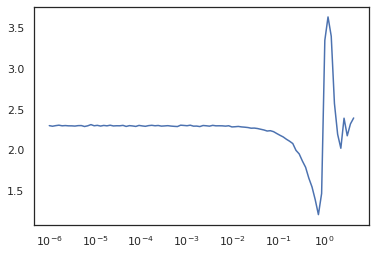

In [62]:
run.recorder.plot(skip_last=5)

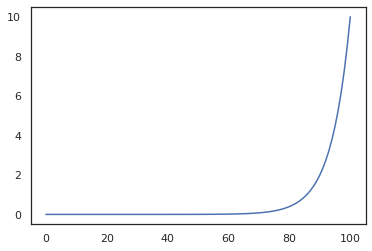

In [63]:
run.recorder.plot_lr()